<a href="https://colab.research.google.com/github/2yoojin/capstone/blob/main/AA_Decompose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.core.nanops import nanmean as pd_nanmean
from statsmodels.tsa.seasonal import DecomposeResult
# from statsmodels.tsa.filters._utils import _maybe_get_pandas_wrapper_freq
# from statsmodels.tsa.filters._utils import _get_pandas_wrapper
import statsmodels.api as sm
from matplotlib import rcParams
import warnings
warnings.filterwarnings(action='ignore')

from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv('/content/drive/My Drive/HanRiver_dataset(2010~2023).csv')
data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,fw,wl,wlobscd,ymdhm,observatory,interest,attention,caution,serious,latitude,longitude,datetime,date,year,month,day,hour,rf,warning level
0,6.08,1.78,1018655,2010010100,Daegok Bridge,3.8,5.5,7.0,8.5,37.468742,127.122572,2010-01-01 00:00:00,2010-01-01,2010,1,1,0,0.0,normal
1,6.08,1.78,1018655,2010010101,Daegok Bridge,3.8,5.5,7.0,8.5,37.468742,127.122572,2010-01-01 01:00:00,2010-01-01,2010,1,1,1,0.0,normal
2,6.08,1.78,1018655,2010010102,Daegok Bridge,3.8,5.5,7.0,8.5,37.468742,127.122572,2010-01-01 02:00:00,2010-01-01,2010,1,1,2,0.0,normal
3,6.08,1.78,1018655,2010010103,Daegok Bridge,3.8,5.5,7.0,8.5,37.468742,127.122572,2010-01-01 03:00:00,2010-01-01,2010,1,1,3,0.0,normal
4,6.08,1.78,1018655,2010010104,Daegok Bridge,3.8,5.5,7.0,8.5,37.468742,127.122572,2010-01-01 04:00:00,2010-01-01,2010,1,1,4,0.0,normal


In [153]:
def get_observatory(data, name):
  df_dec = data[data['observatory'] ==   name]
  df_dec.set_index('datetime', inplace=True)
  df_dec = df_dec[['wl']]
  warning_level = data[['observatory', 'interest', 'attention', 'caution', 'serious']]
  warning_level = warning_level.drop_duplicates().reset_index(drop=True)
  warning_level = warning_level[warning_level['observatory'] == name]
  return df_dec, warning_level


In [146]:
from functools import wraps
from statsmodels.tools.data import _is_using_pandas
from statsmodels.tsa.base import datetools
from statsmodels.tsa.tsatools import freq_to_period

def _pandas_wrapper(X, trim_head=None, trim_tail=None, names=None):
    index = X.index
    #TODO: allow use index labels
    if trim_head is None and trim_tail is None:
        index = index
    elif trim_tail is None:
        index = index[trim_head:]
    elif trim_head is None:
        index = index[:-trim_tail]
    else:
        index = index[trim_head:-trim_tail]
    if hasattr(X, "columns"):
        if names is None:
            names = X.columns
        # 데이터프레임 객체를 반환하도록 수정
        return X.__class__(X.values, index=index, columns=names)
    else:
        if names is None:
            names = X.name
        # 데이터프레임 객체를 반환하도록 수정
        return X.__class__(X.values, index=index, name=names)

# def anomaly_detection(points, thresh=3.5):
#     if len(points.shape) == 1:
#         points = points[:, None]
#     median = np.median(points, axis=0)
#     diff = np.sum((points - median)**2, axis=-1)
#     diff = np.sqrt(diff)
#     med_abs_deviation = np.median(diff)
#     modified_z_score = 0.6745 * diff / med_abs_deviation
#     return modified_z_score > thresh


def anomaly_detection(point, warning_level):
    warning_levels = np.repeat(warning_level, len(point))
    anomalies = point > warning_level
    return anomalies

# def AA_decompose(df, period=24, lo_frac=0.6, lo_delta=0.01, thresh=3.5):
#     lowess = sm.nonparametric.lowess
#     _pandas_wrapper = _get_pandas_wrapper(df)
#     observed = np.asanyarray(df).squeeze()
#     trend = lowess(observed, [x for x in range(len(observed))],
#                    frac=lo_frac,
#                    delta=lo_delta * len(observed),
#                    return_sorted=False)
#     detrended = observed / trend
#     period = min(period, len(observed))
#     period_median = np.array([pd_nanmean(detrended[i::period])
#                               for i in range(period)])
#     seasonal = np.repeat(period_median, len(observed) // period + 1)[:len(observed)]

#     resid_inter = detrended / seasonal
#     resid_inter[0] = 1
#     resid = resid_inter.copy()
#     anomalies = resid_inter.copy()
#     b = anomaly_detection(resid, thresh=thresh)
#     for j in range(len(b)):
#         if b[j] == True:
#             resid[j] = 1
#         if b[j] == False:
#             anomalies[j] = 1
#     results = list(map(_pandas_wrapper, [seasonal, trend, resid, observed]))
#     #results = list(map(df, [seasonal, trend, resid, observed]))
#     fig, axes = plt.subplots(5, 1, sharex=True, figsize=(10,12))

#     axes[0].plot(observed)
#     axes[0].set_ylabel('Water Level')
#     axes[1].plot(trend)
#     axes[1].set_ylabel('Trend')
#     axes[2].plot(seasonal)
#     axes[2].set_ylabel('Seasonal')
#     axes[4].plot(anomalies, color='r')
#     axes[4].set_ylabel('Anomalies')
#     axes[4].set_xlabel('Time')

#     axes[3].plot(resid)
#     axes[3].set_ylabel('Residual')
#     axes[3].set_xlabel('Time')
#     plt.tight_layout()
#     plt.show()
#     return trend, seasonal, anomalies, resid

def AA_decompose(df, period=24, lo_frac=0.6, lo_delta=0.01, warning_level=None):
    lowess = sm.nonparametric.lowess
    # _pandas_wrapper = _get_pandas_wrapper(df)
    # _pandas_wrapper = df
    water_level = np.asanyarray(df).squeeze()

    anomalies = anomaly_detection(water_level, warning_level)
    water_level = water_level[~anomalies]

    trend = lowess(water_level, [x for x in range(len(water_level))],
                   frac=lo_frac,
                   delta=lo_delta * len(water_level),
                   return_sorted=False)
    detrended = water_level / trend
    period = min(period, len(water_level))
    period_median = np.array([pd_nanmean(detrended[i::period])
                              for i in range(period)])

    seasonal = np.tile(period_median, len(water_level) // period + 1)[:len(water_level)]
    # seasonal = np.repeat(period_median, len(water_level) // period + 1)[:len(water_level)]

    # seasonal = np.zeros_like(water_level)
    # n = len(water_level)
    # for i in range(1, period+1):
    #   seasonal += np.sin(2 * np.pi * i * np.arange(n) / period)
    # seasonal /= period

    resid_inter = detrended / seasonal
    resid_inter[0] = 1
    resid = resid_inter.copy()

    # results = list(map(_pandas_wrapper, [seasonal, trend, resid, water_level]))

    fig, axes = plt.subplots(5, 1, sharex=True, figsize=(10,12))

    axes[0].plot(water_level)
    axes[0].set_ylabel('Water Level')
    axes[1].plot(trend)
    axes[1].set_ylabel('Trend')
    axes[2].plot(seasonal)
    axes[2].set_ylabel('Seasonal')

    axes[3].plot(resid)
    axes[3].set_ylabel('Residual')
    axes[3].set_xlabel('Time')

    axes[4].plot(anomalies, color='r')
    axes[4].set_ylabel('Anomalies')
    axes[4].set_xlabel('Time')
    plt.tight_layout()
    plt.show()
    return trend, seasonal, anomalies, resid

plt.rc('font', family='serif')
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

params = {
    'axes.labelsize': 8,
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'text.usetex': False,
    'figure.figsize': [4.5, 4.5]
}
rcParams.update(params)

#trend, seasonal, anomalies, resid  = AA_decompose(df_dec, period=4, warning_level=warning_level['interest'].iloc[0])/

In [154]:
df_dec, warning_level = get_observatory(data, 'Jamsu Bridge')

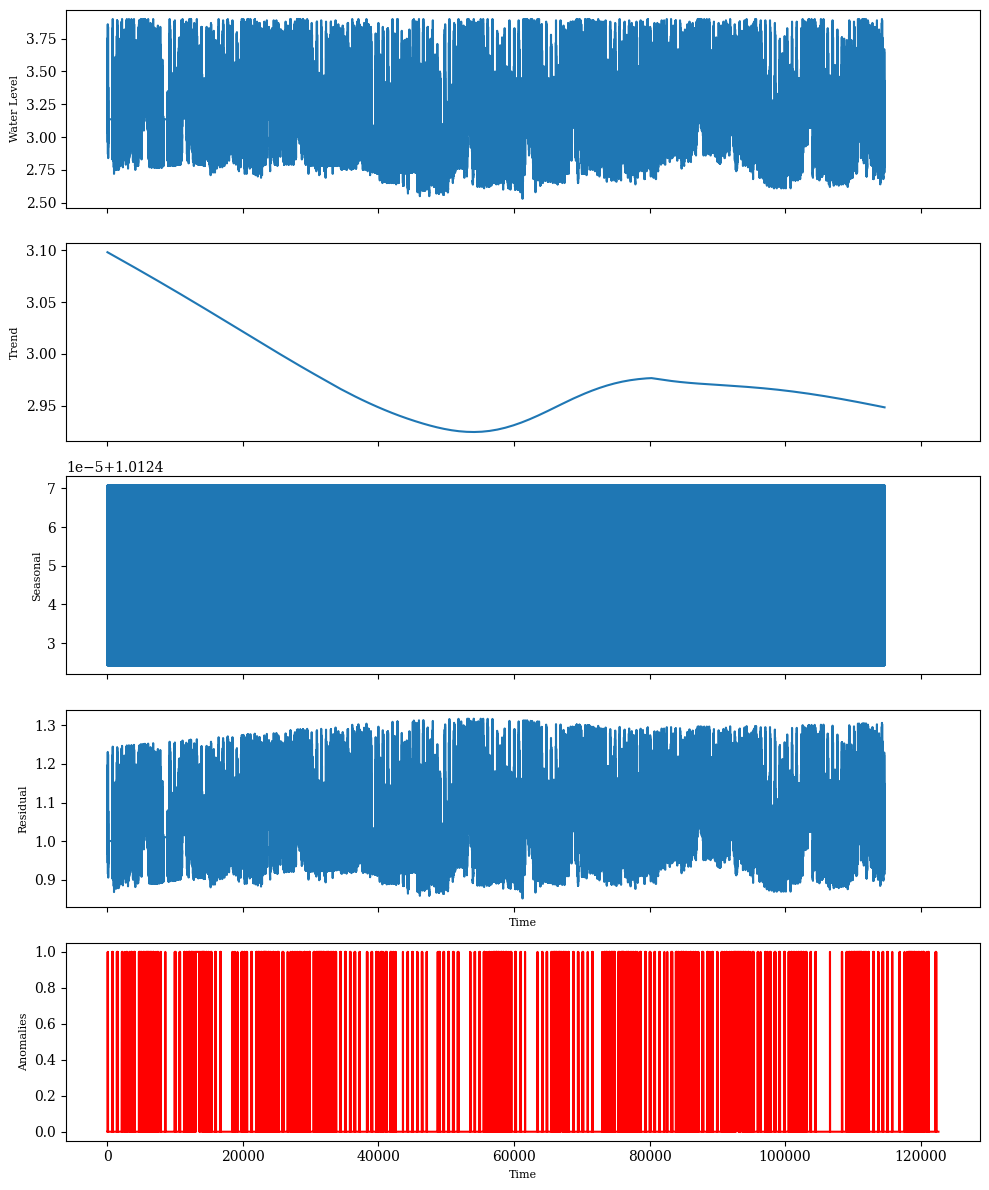

In [155]:
trend, seasonal, anomalies, resid  = AA_decompose(df_dec, period=4, warning_level=warning_level['interest'].iloc[0])

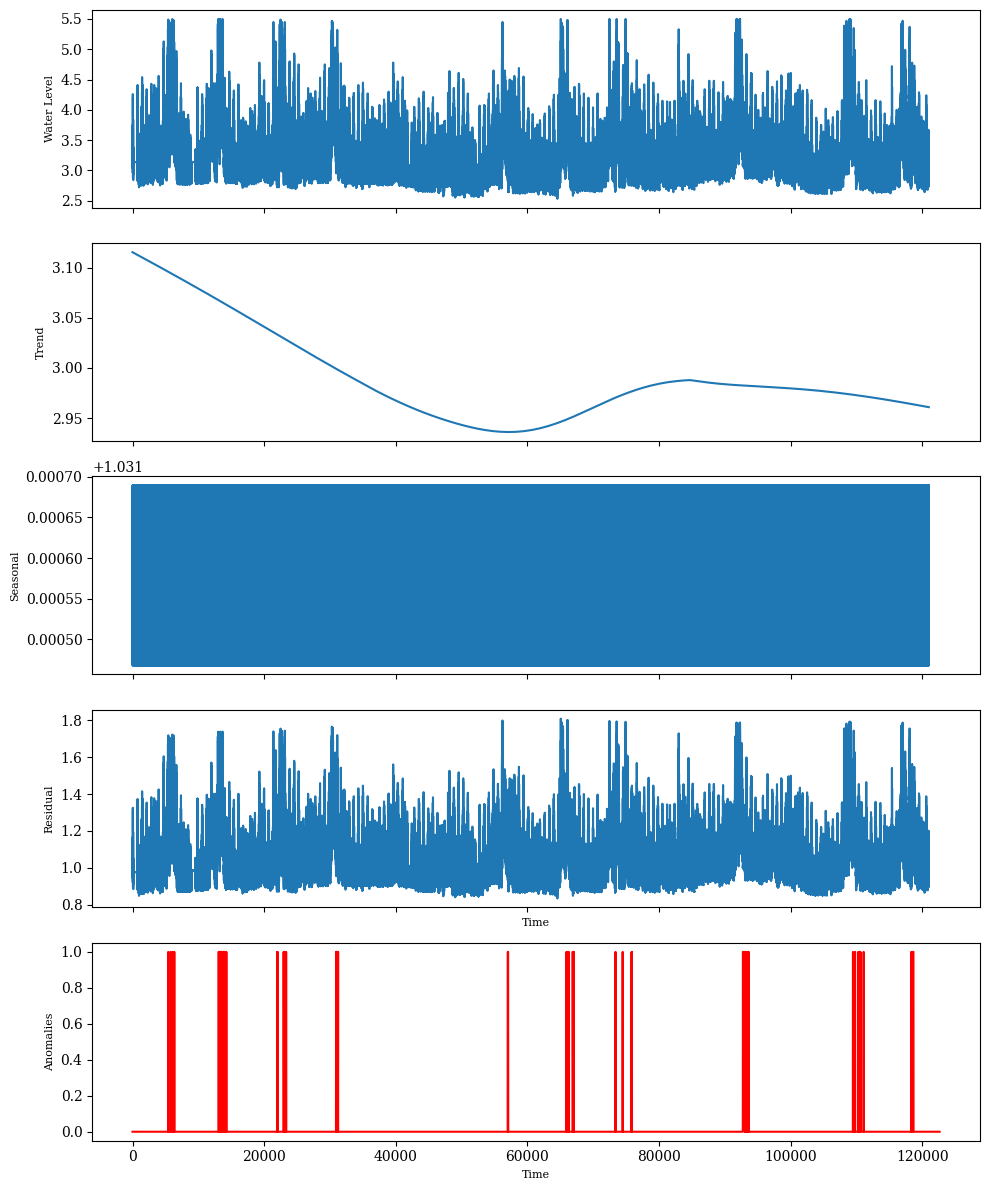

In [133]:
trend, seasonal, anomalies, resid  = AA_decompose(df_dec, period=4, warning_level=warning_level['attetion'].iloc[0])

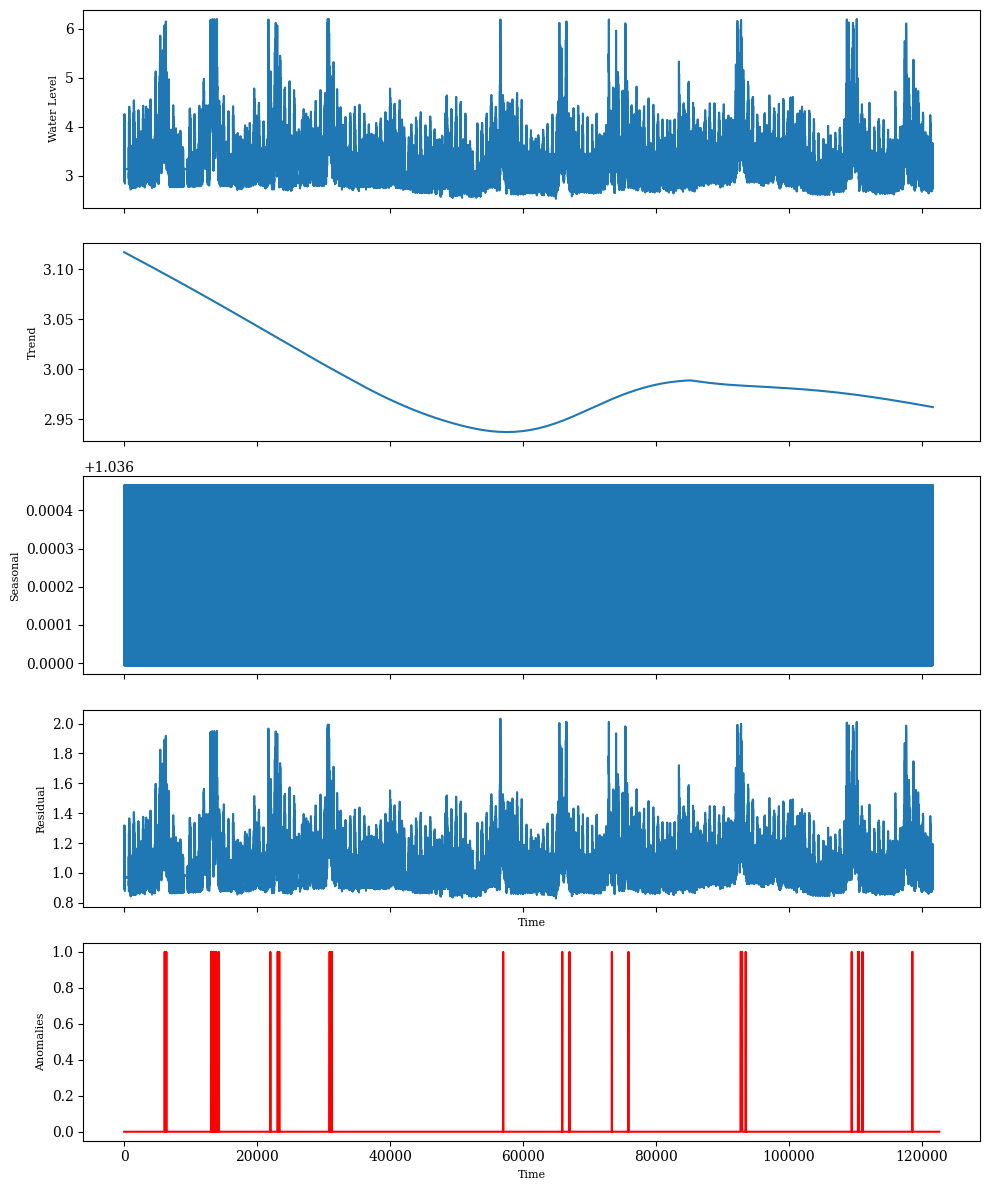

In [134]:
trend, seasonal, anomalies, resid  = AA_decompose(df_dec, period=4, warning_level=warning_level['caution'].iloc[0])

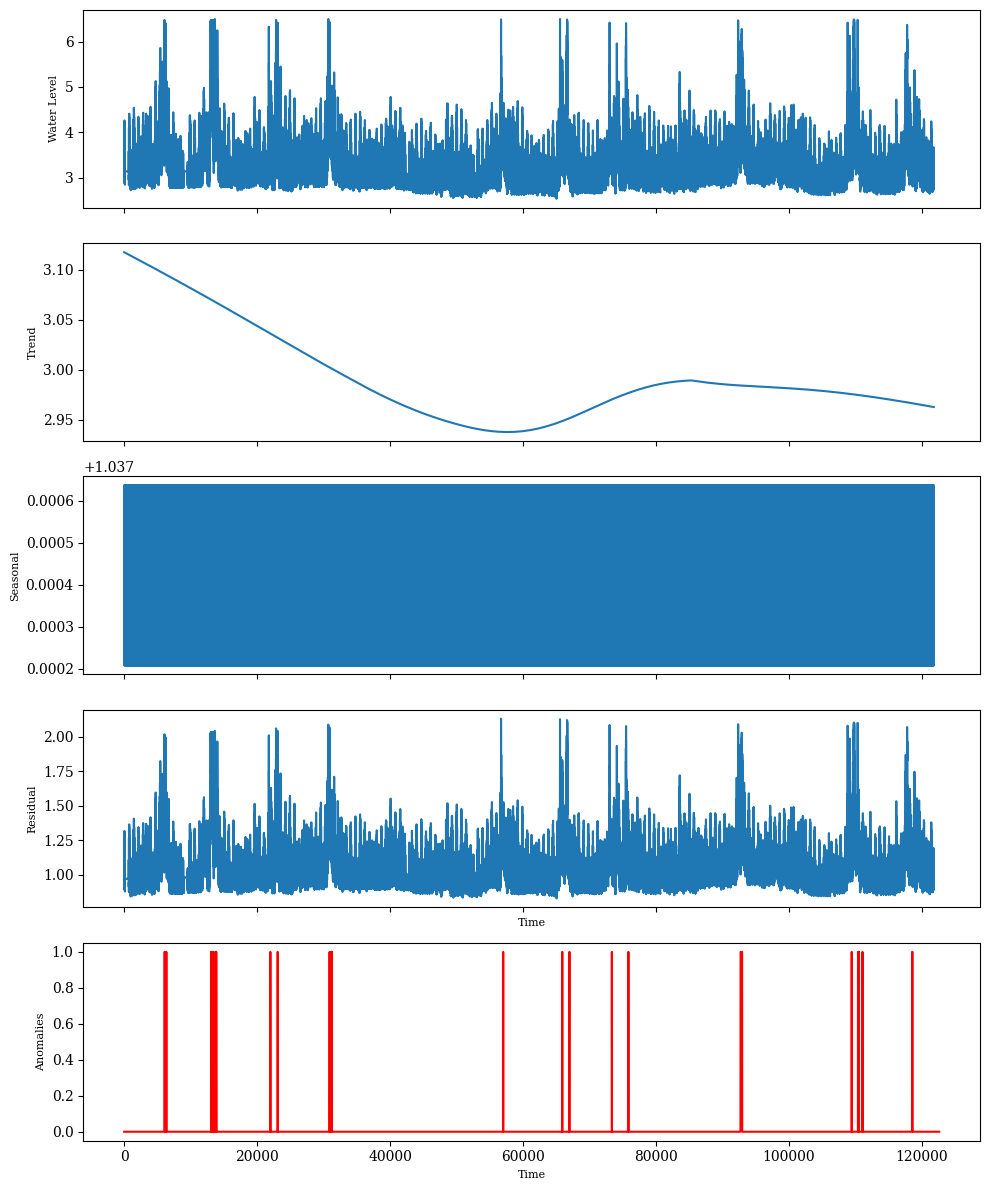

In [135]:
trend, seasonal, anomalies, resid  = AA_decompose(df_dec, period=4, warning_level=warning_level['serious'].iloc[0])

In [156]:
df_dec, warning_level = get_observatory(data, 'Neobu Bridge')

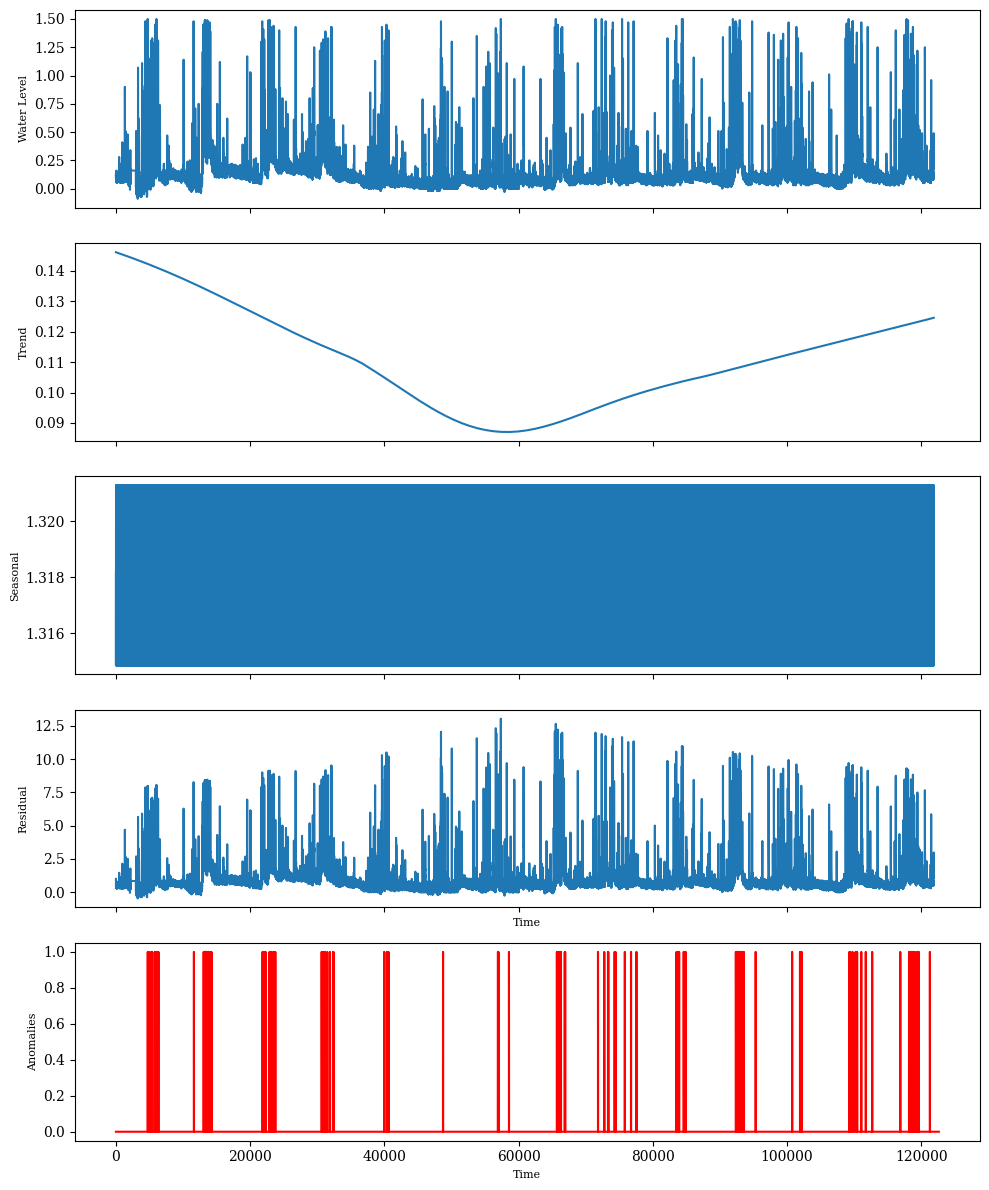

In [157]:
trend, seasonal, anomalies, resid  = AA_decompose(df_dec, period=4, warning_level=warning_level['interest'].iloc[0])

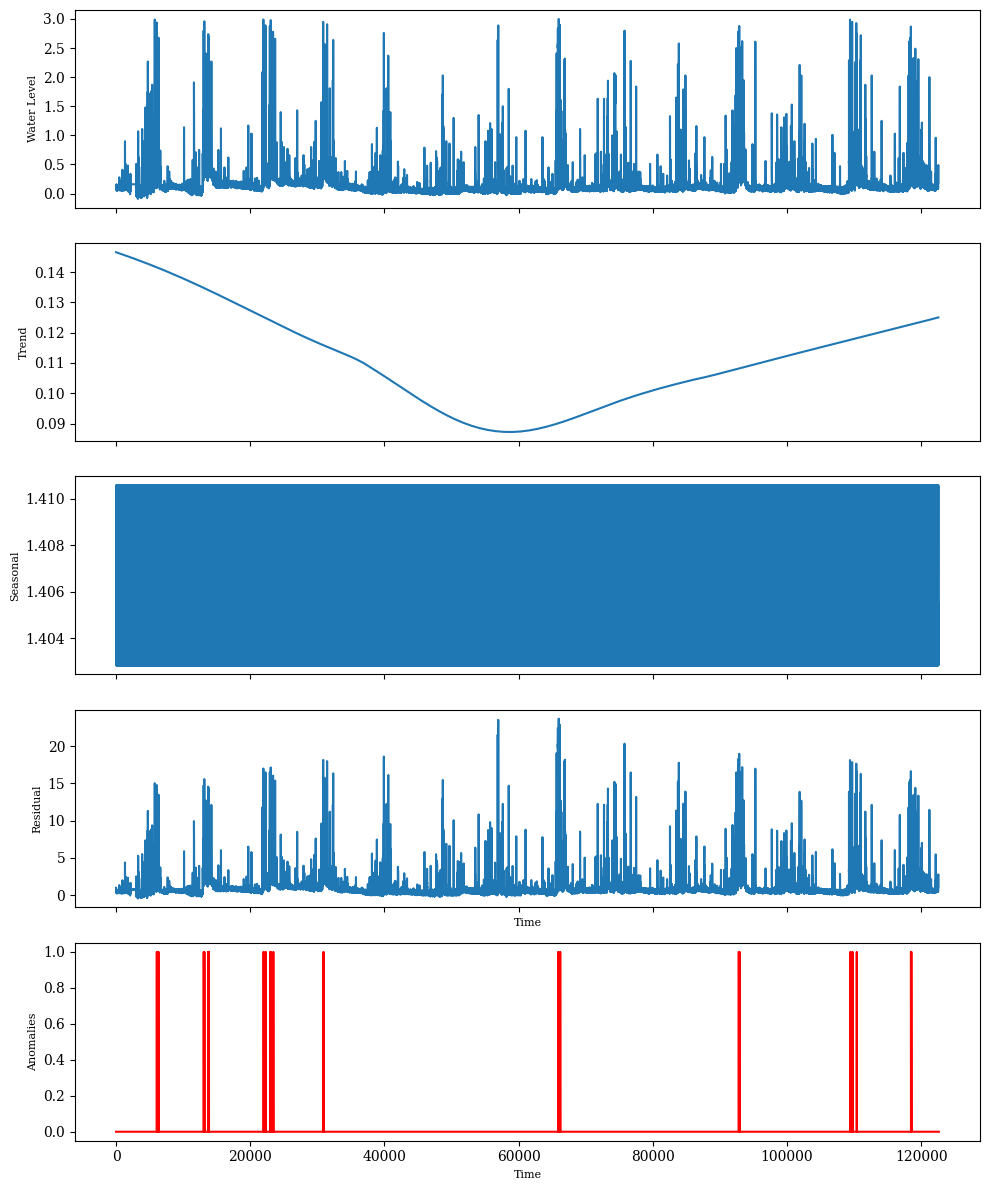

In [158]:
trend, seasonal, anomalies, resid  = AA_decompose(df_dec, period=4, warning_level=warning_level['attention'].iloc[0])

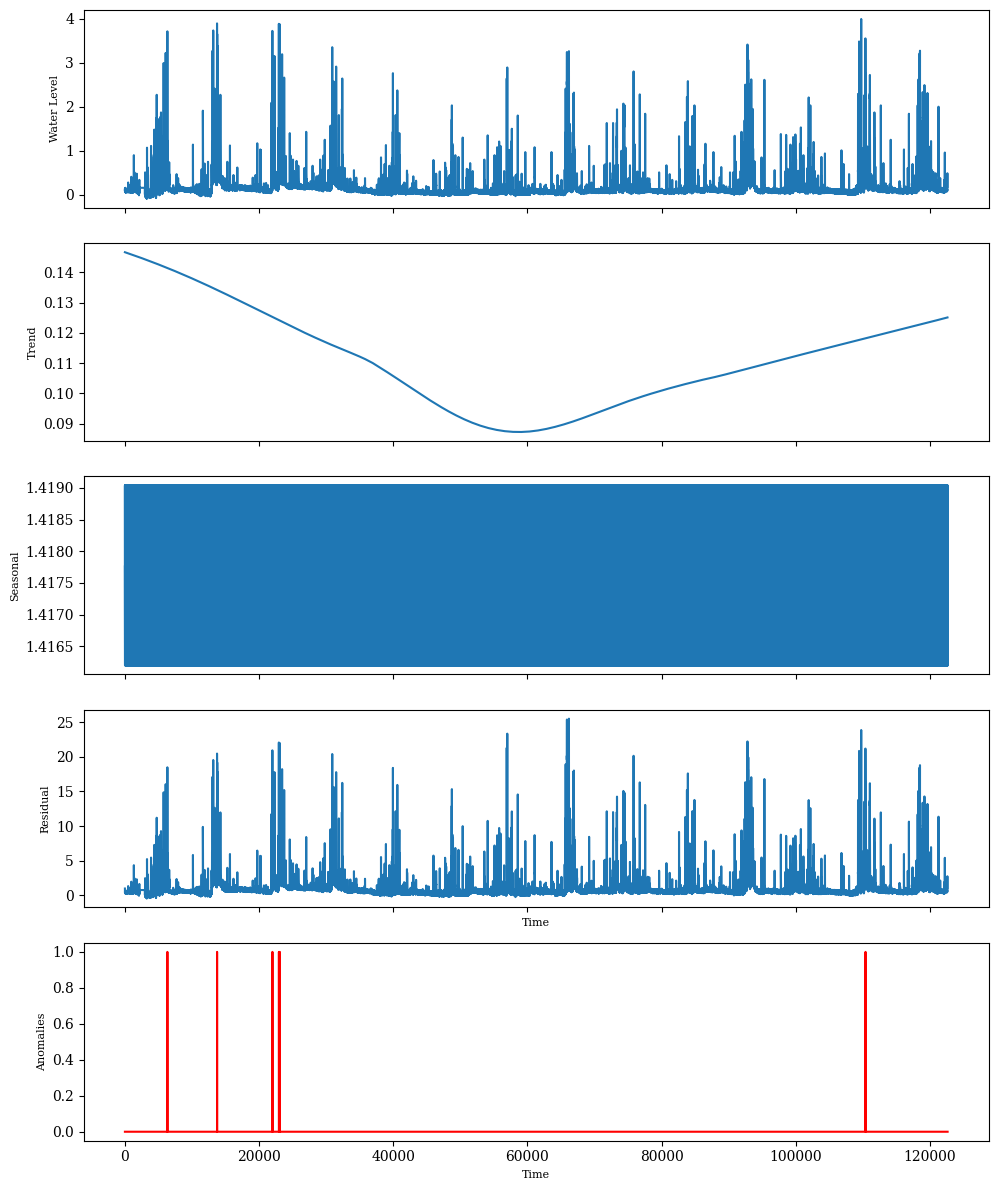

In [159]:
trend, seasonal, anomalies, resid  = AA_decompose(df_dec, period=4, warning_level=warning_level['caution'].iloc[0])

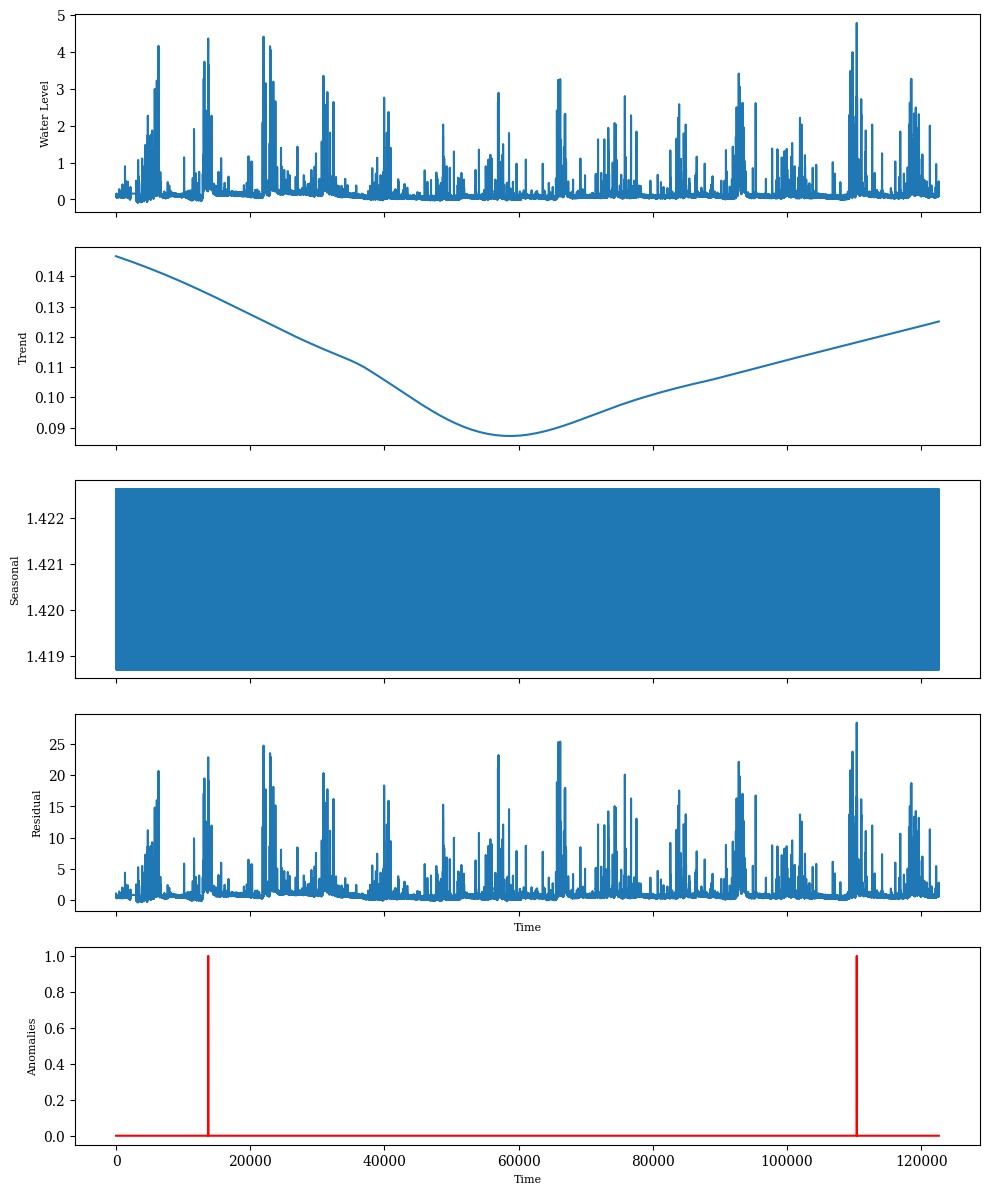

In [160]:
trend, seasonal, anomalies, resid  = AA_decompose(df_dec, period=4, warning_level=warning_level['serious'].iloc[0])

In [162]:
df_dec, warning_level = get_observatory(data, 'Haengju Bridge')

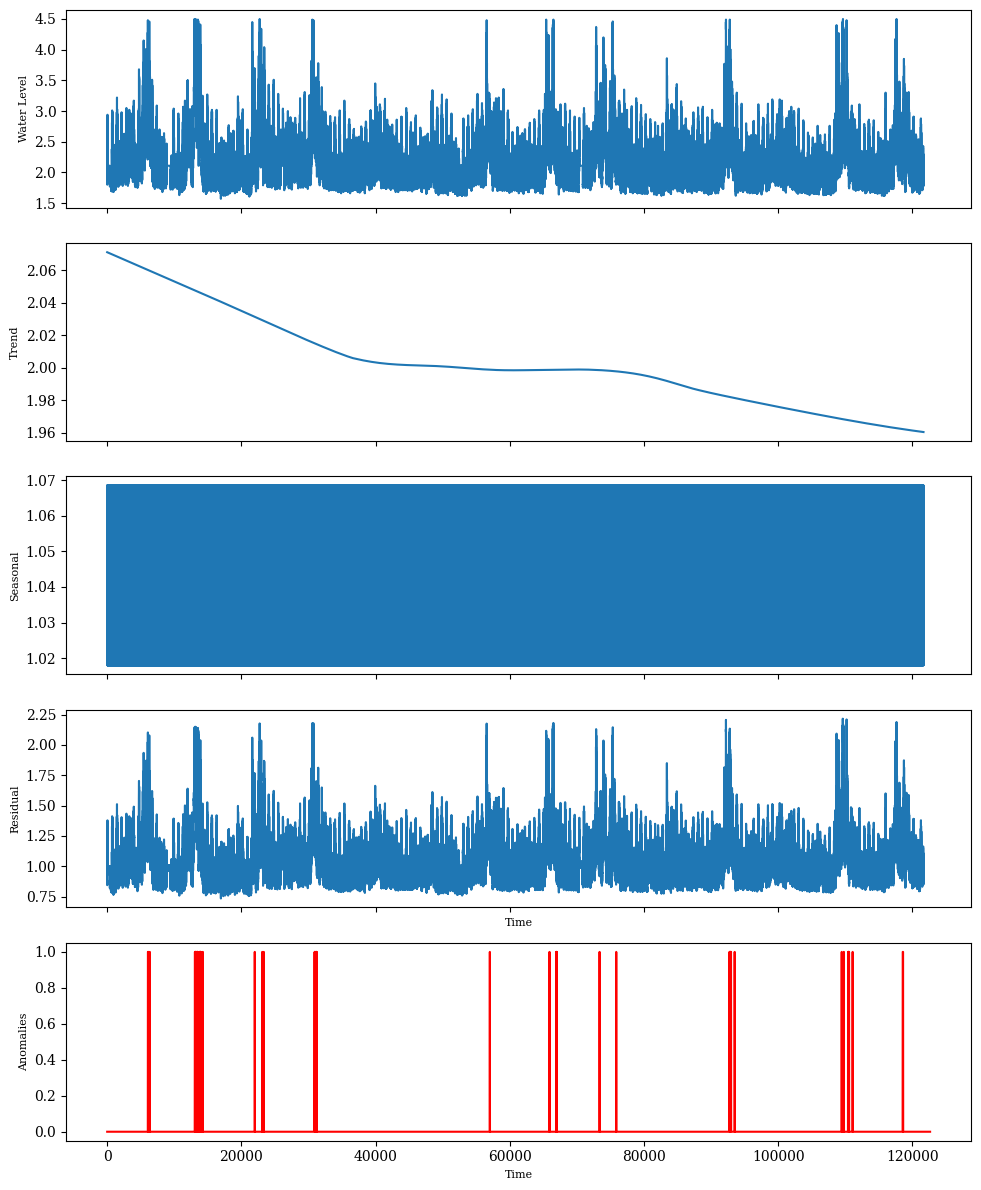

In [163]:
trend, seasonal, anomalies, resid  = AA_decompose(df_dec, period=24, warning_level=warning_level['interest'].iloc[0])

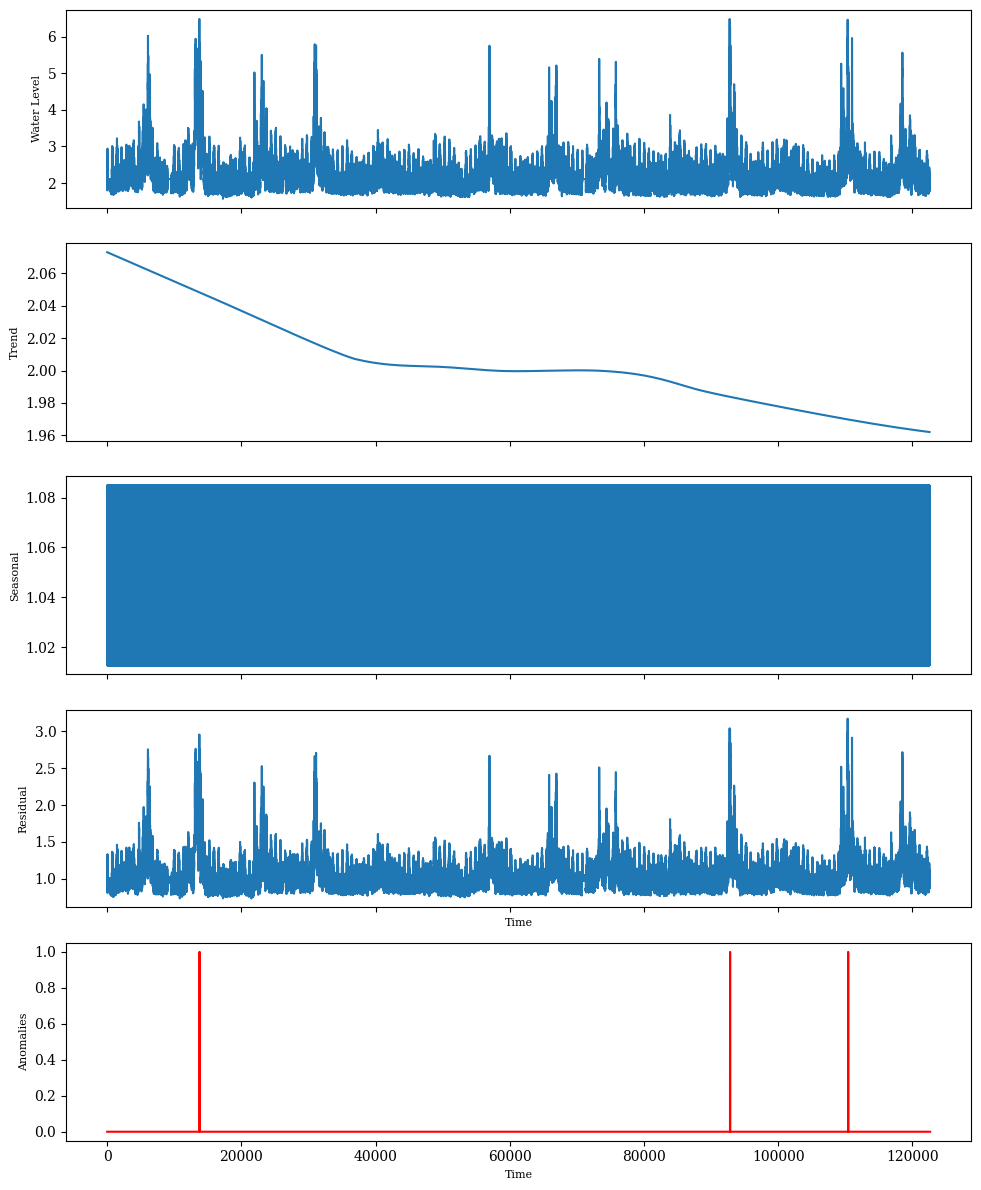

In [164]:
trend, seasonal, anomalies, resid  = AA_decompose(df_dec, period=24, warning_level=warning_level['attention'].iloc[0])

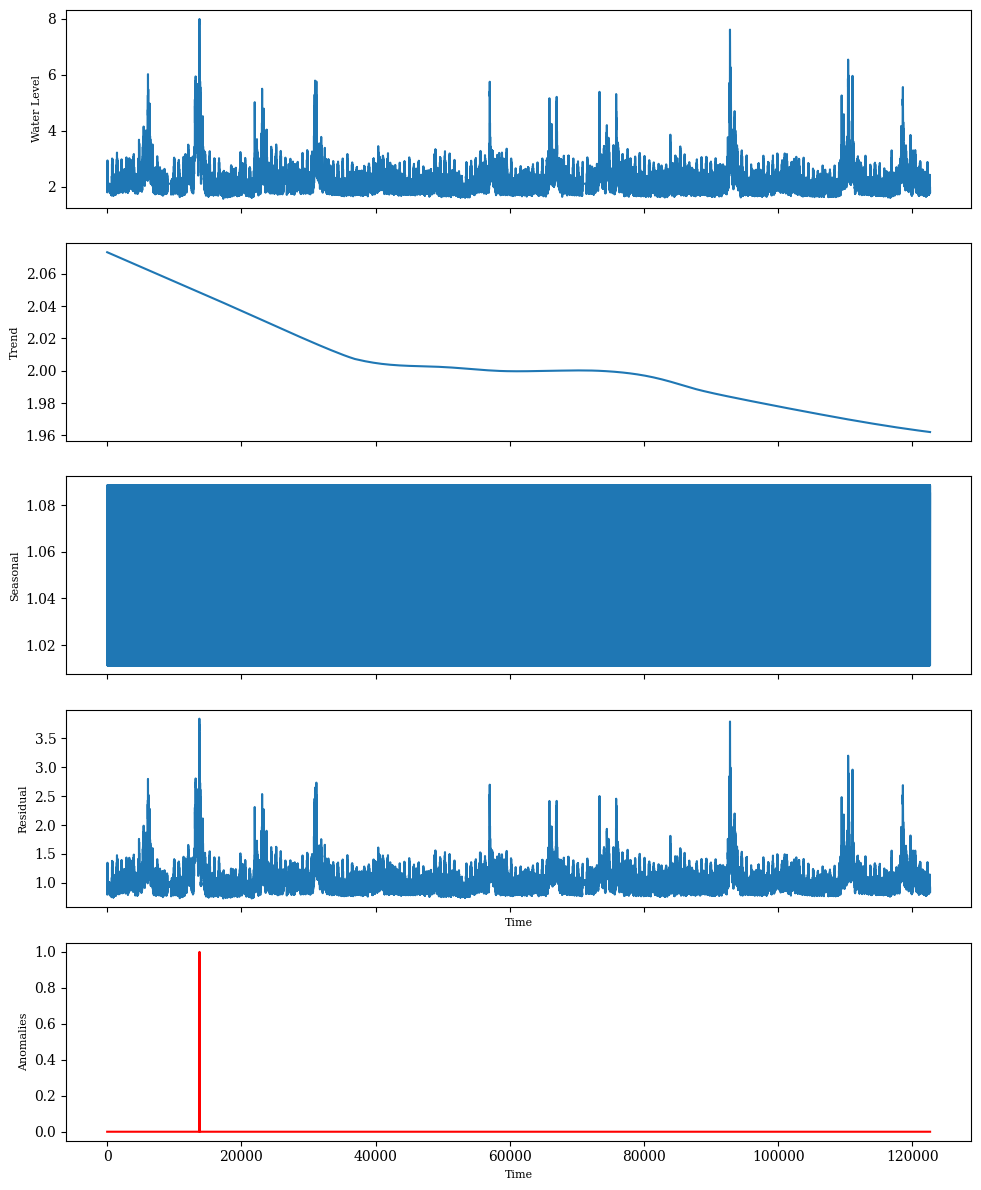

In [165]:
trend, seasonal, anomalies, resid  = AA_decompose(df_dec, period=24, warning_level=warning_level['caution'].iloc[0])

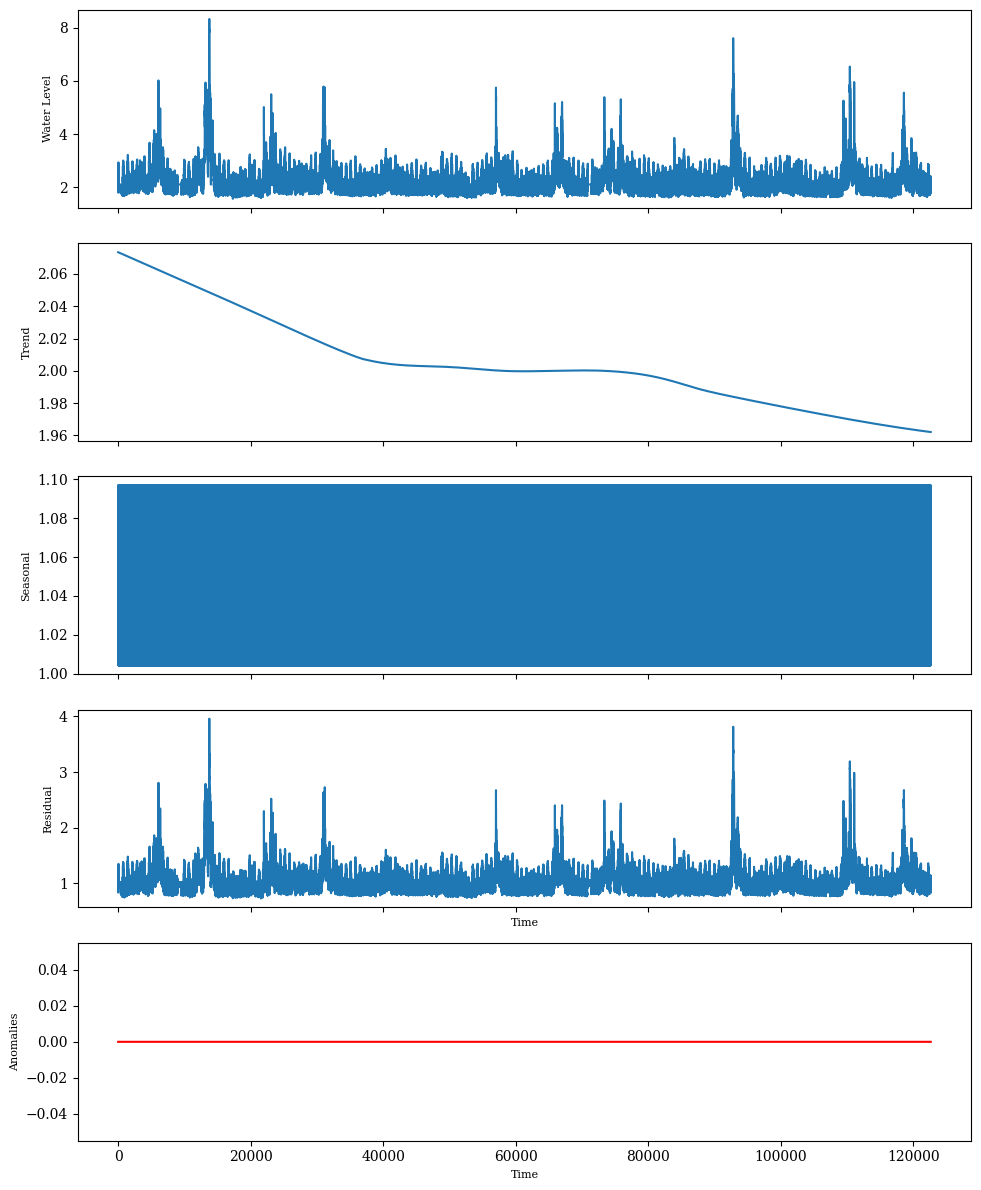

In [166]:
trend, seasonal, anomalies, resid  = AA_decompose(df_dec, period=24, warning_level=warning_level['serious'].iloc[0])